In [16]:
import os
import numpy as np
from obspy import read, Trace
from obspy.clients.fdsn.header import FDSNException
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import xml.etree.ElementTree as ET
import pyproj
import matplotlib.pyplot as plt
from scipy.io import savemat #for save obspy object as matlab format

# Synthetics


In [19]:
def ReadSeisSolSeismogram(folderprefix, idst, coords_only=False):
    """READ seissol receiver nb i"""
    mytemplate = "%s-receiver-%05d*" % (folderprefix, idst)
    f = os.popen("ls " + mytemplate)
    now = f.read()
    myfile = now.strip()
    if myfile == "":
        return False
    fid = open(myfile)
    fid.readline()
    variablelist = fid.readline()[11:].split(",")
    variablelist = np.array([a.strip().strip('"') for a in variablelist])
    xsyn = float(fid.readline().split()[2])
    ysyn = float(fid.readline().split()[2])
    zsyn = float(fid.readline().split()[2])
    if coords_only:
        return [xsyn, ysyn, zsyn]
    synth = np.loadtxt(fid)
    fid.close()
    return ([xsyn, ysyn, zsyn], variablelist, synth)


In [20]:
def CreateObspyTraceFromSeissolSeismogram(station, variablelist, synth, starttime):
    """Load synthetics into an obspy stream"""
    st_syn = read()
    st_syn.clear()
    xyz = "ENZ"
    uvw = "uvw"
    for i in range(0, 3):
        j = np.where(variablelist == uvw[i])[0]
        try:
            j = j[0]
        except IndexError:
            print("uvw[i] = %s not in variable list:" % (uvw[i]), variablelist)
            raise ("uvw[i] not found in variable list")
        tr = Trace()
        # tr.stats.station = station +'.'+ xyz[i]
        tr.stats.station = station
        tr.stats.channel = xyz[i]
        tr.data = synth[:, j]
        tr.stats.delta = synth[1, 0] - synth[0, 0]
        tr.stats.starttime = starttime
        st_syn.append(tr)
    return st_syn


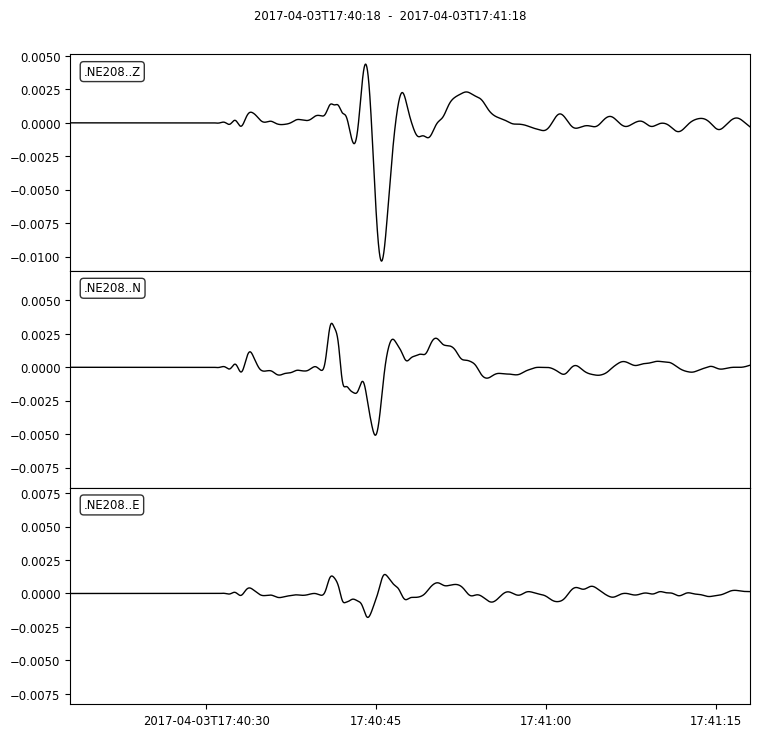

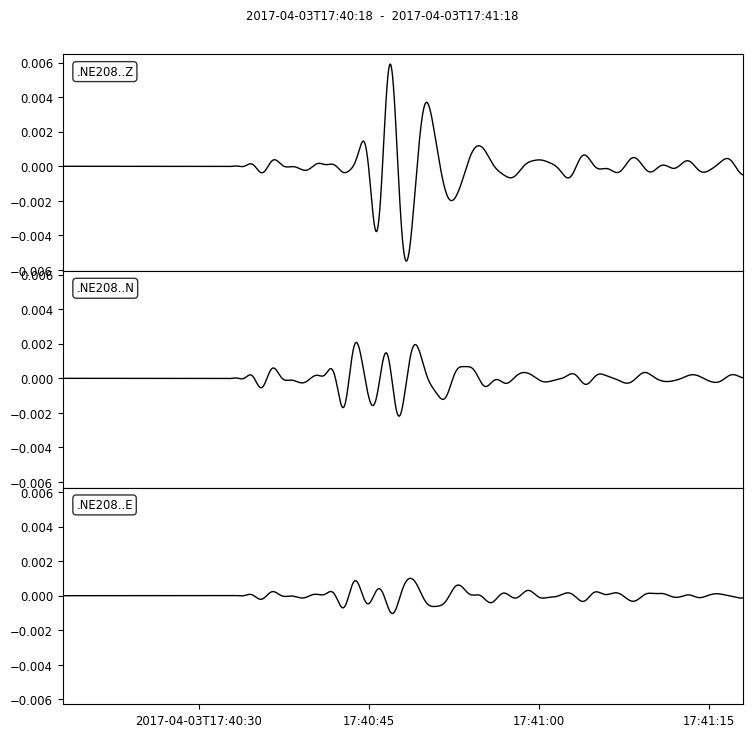

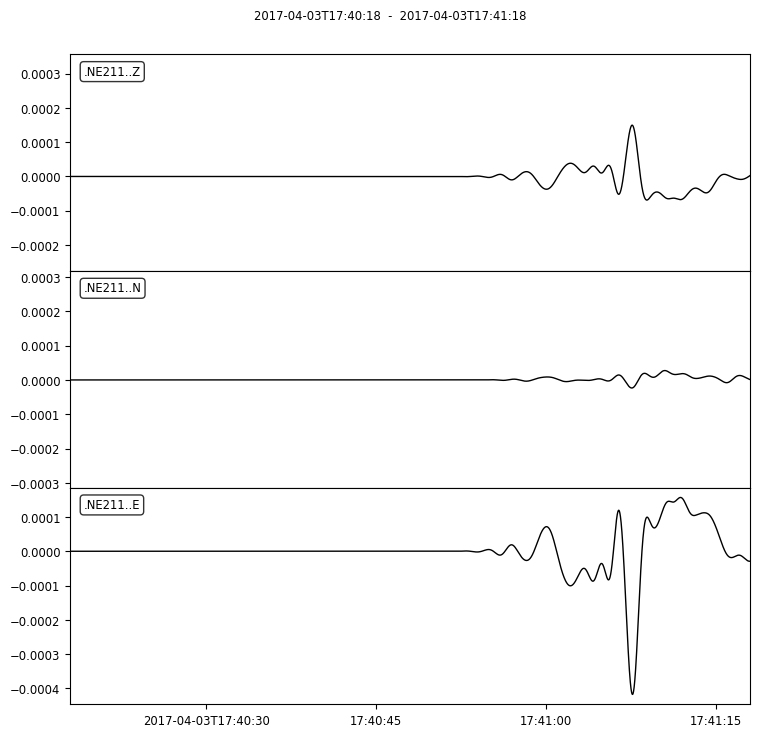

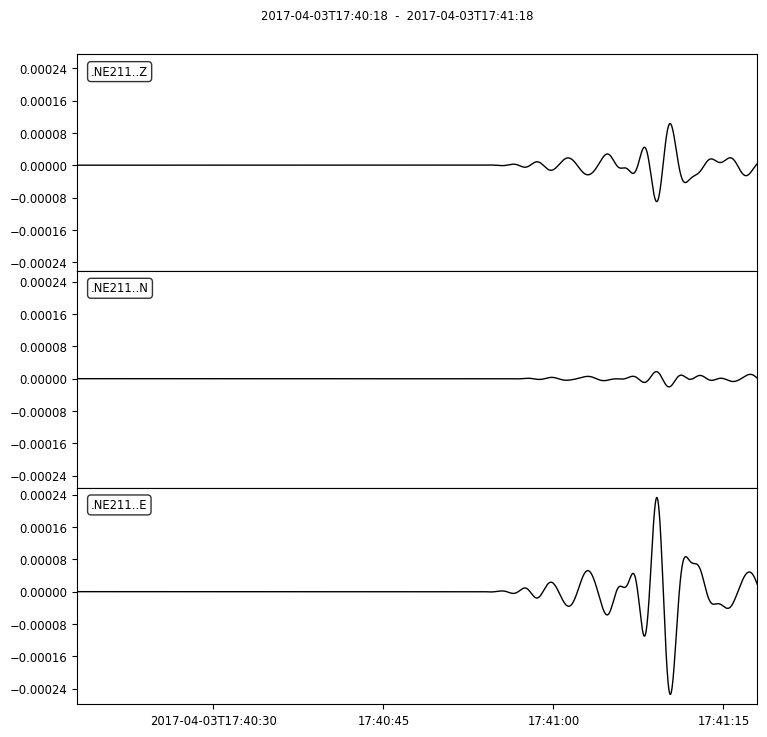

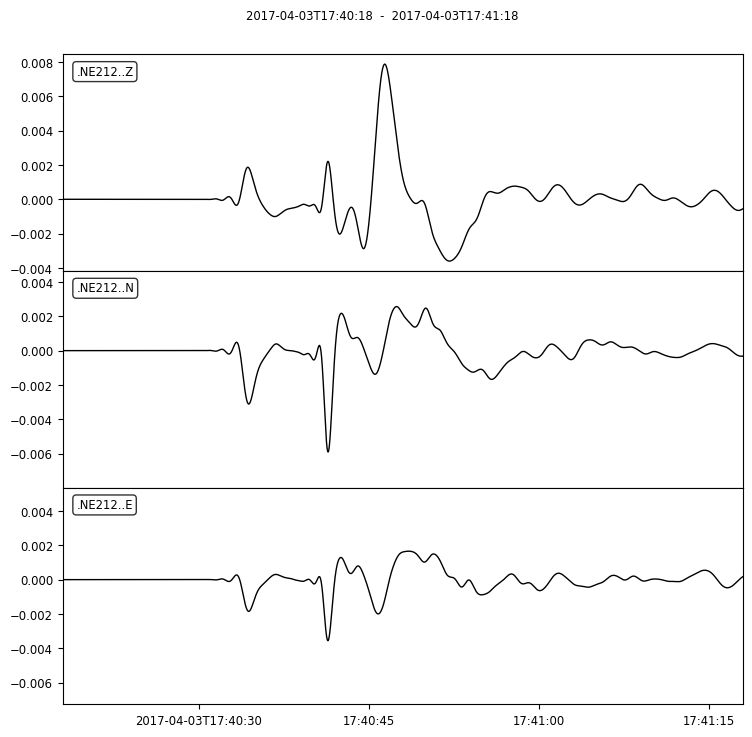

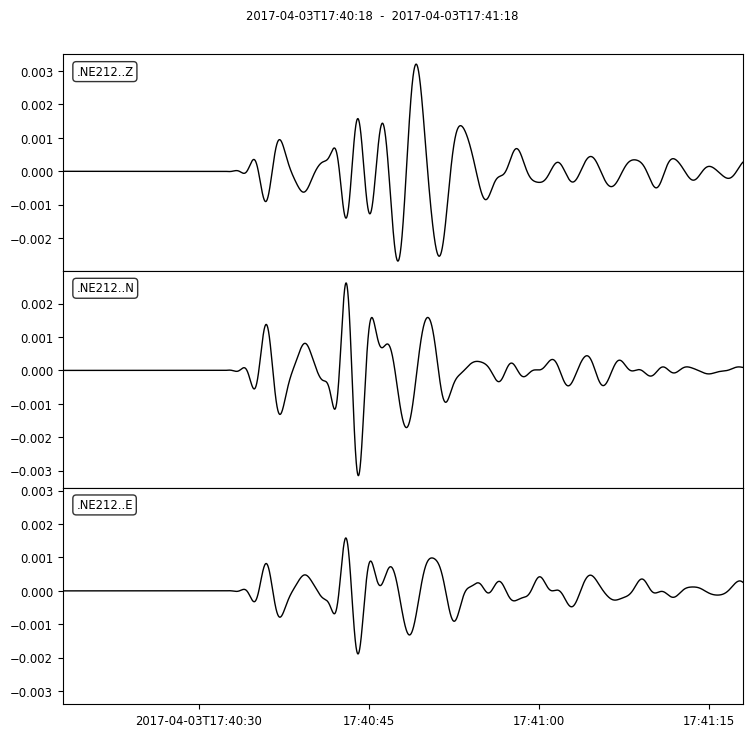

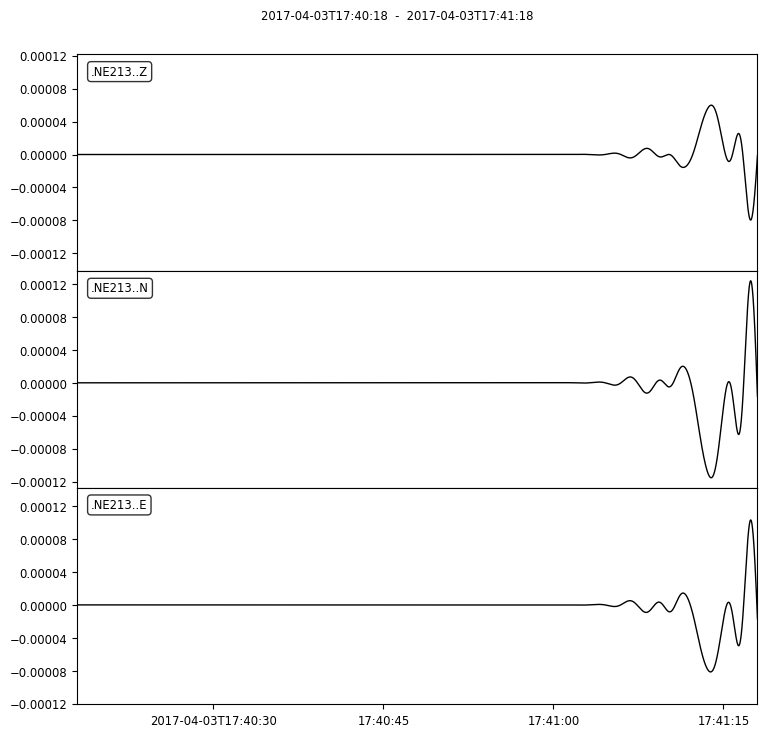

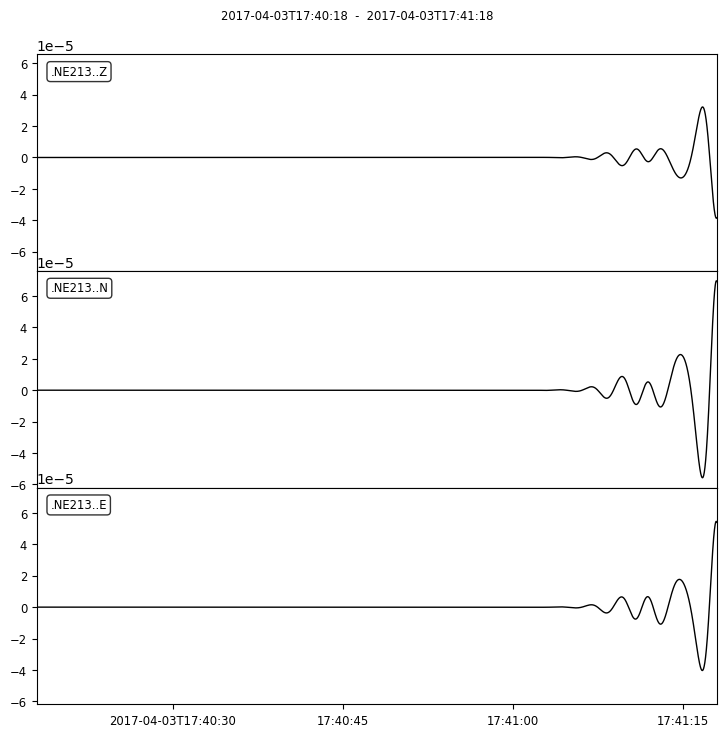

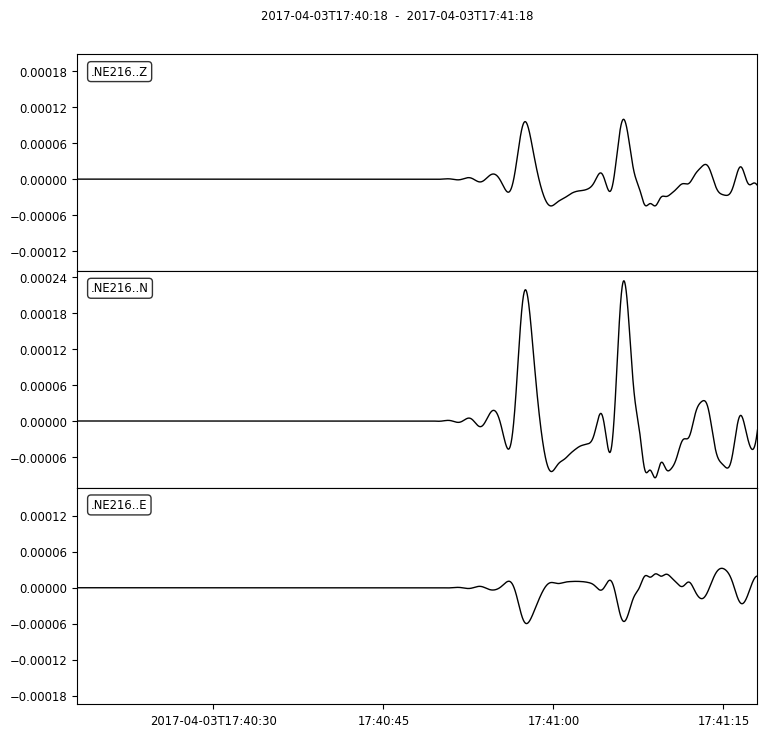

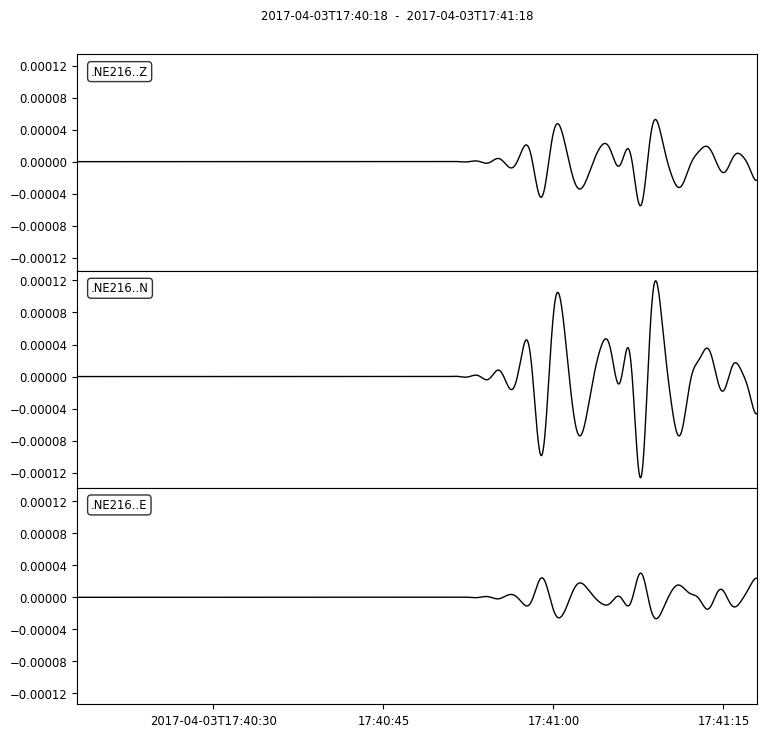

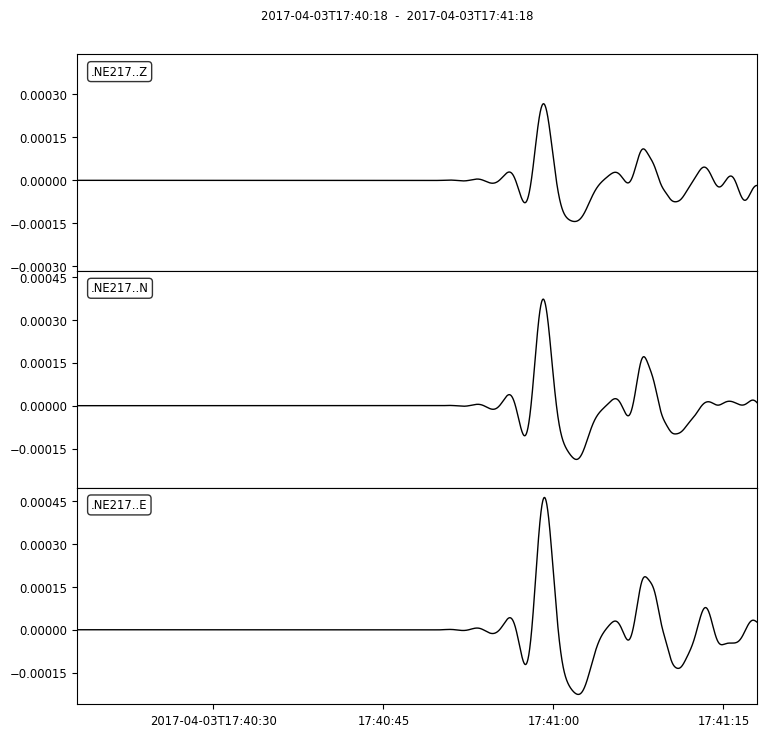

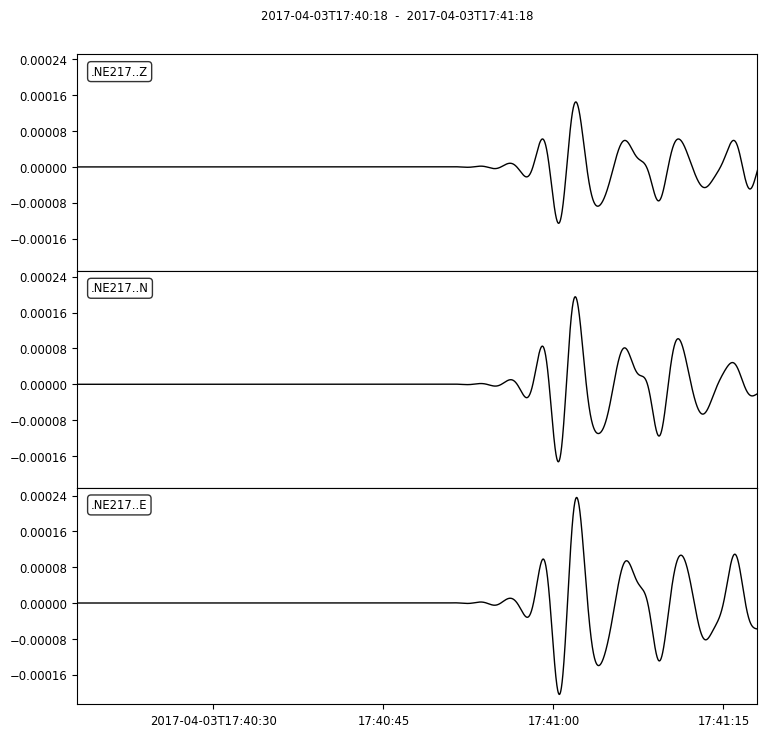

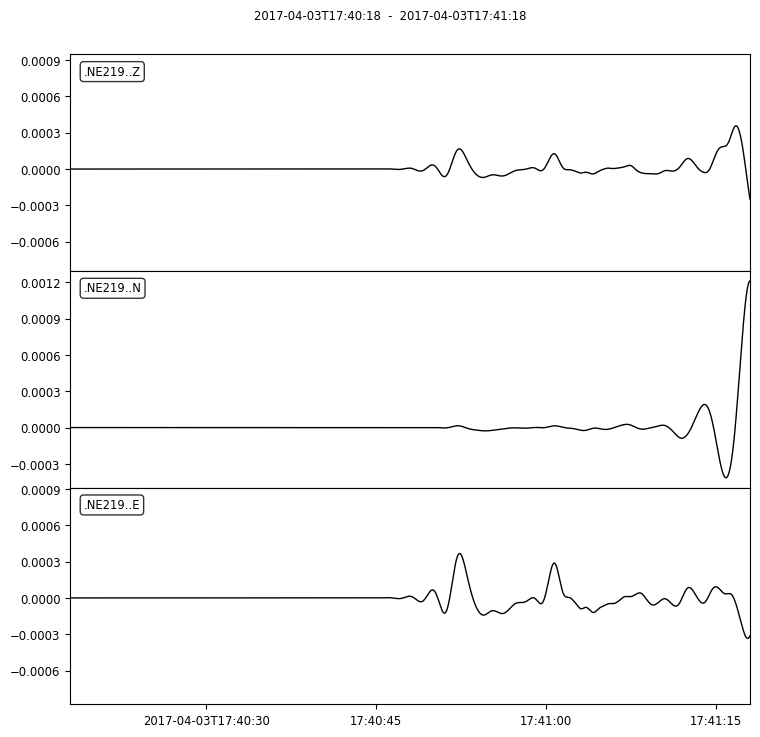

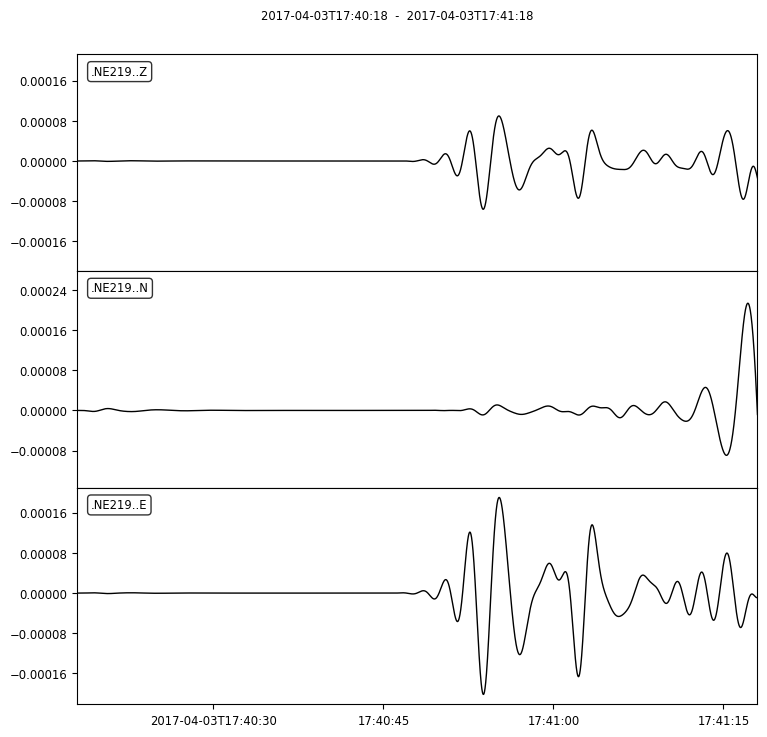

In [31]:
folderprefix = "../syn/botswana_model_5_l4_60s"
#folderprefix = "../syn/botswana_model_700kmr6_new"
starttime = UTCDateTime(2017, 4, 3, 17, 40, 18)

idst = [3,5,6,7,8,9,11]
sta = ["NE208", "NE211", "NE212", "NE213", "NE216", "NE217", "NE219"]

for i,j in enumerate(idst):
    [my_syn, variable, data] = ReadSeisSolSeismogram(folderprefix, j, coords_only=False)
    station = sta[i]
    my_trace = CreateObspyTraceFromSeissolSeismogram(station,variable, data, starttime )
    my_trace.plot();
    my_trace2=my_trace.copy()
    my_trace2.detrend()
    my_trace3=my_trace2.copy()
    my_trace3.filter("bandpass", freqmin=0.2, freqmax=0.6, corners=4)
    my_trace3.plot();
    for i, tr in enumerate(my_trace3):
        mdict = {k: str(v) for k, v in tr.stats.items()}
        mdict['data'] = tr.data
        savemat("../syn/syn_filtered/Model-L4-" + str(station) + "_"  + str(i) + ".mat", mdict)

# Observational


NR_station_list = ["NE201", "NE208","NE209","NE211","NE212", "NE213", "NE216","NE217","NE218","NE219", "NE220"]   
#NE201 NA
#NE208 YES "clipped"
#NE209 NA
#NE211 YES 
#NE212 YES
#NE213 YES
#NE216 YES
#NE217 YES 
#NE218 NA
#NE219 YES "clean" 
#NE220 NA
ZT_station_list = ["MARA","MRCO","NHAM","NYAT"]
#MARA NA
#MRCO NA
#NHAM NA
#NYAT NA

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 4
plt.rcParams['lines.linewidth'] = 0.5

In [5]:
#2017-4-3T17:40:18
t = UTCDateTime(2017, 4, 3, 17, 40, 18)
lon = 25.1558
lat = -22.6784
client = Client('IRIS')
inventory = client.get_stations(
    starttime=t-100, endtime=t+100,
    longitude=lon, latitude=lat, maxradius=7,
    matchtimeseries=None)
#print(inventory)

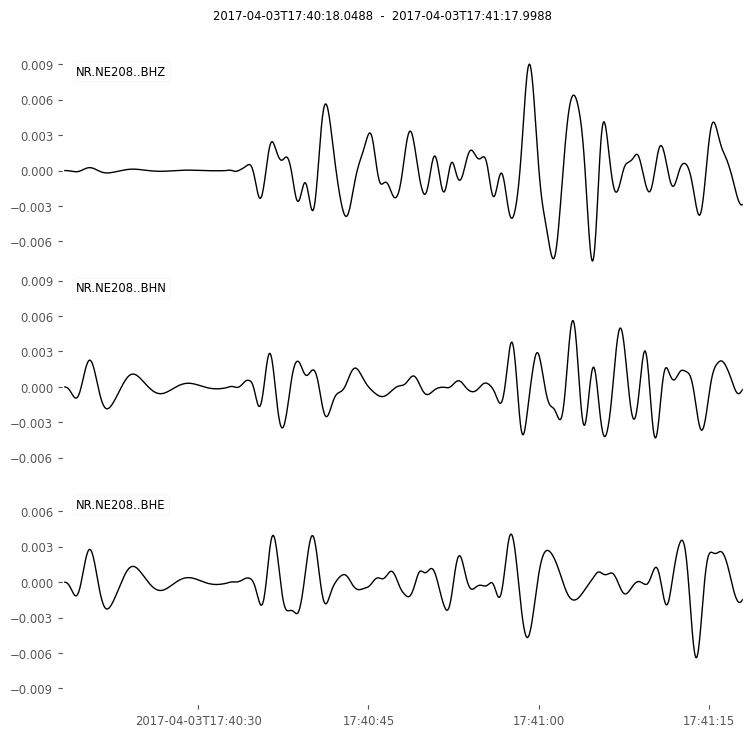

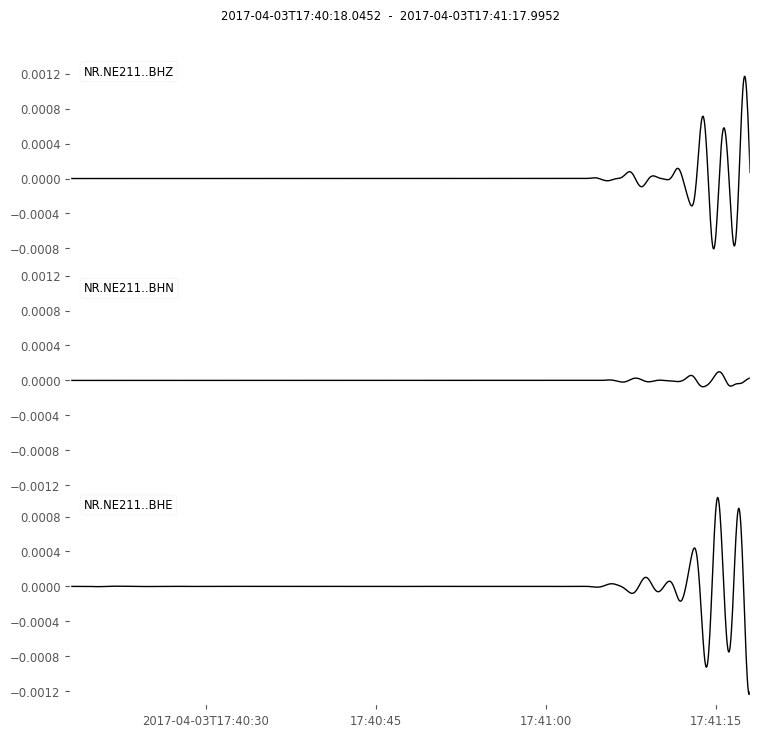

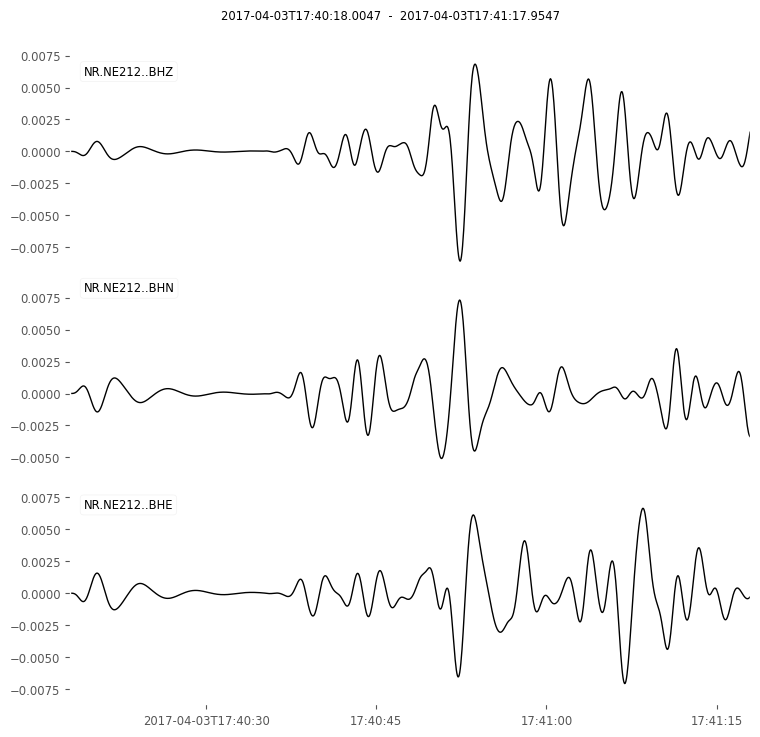

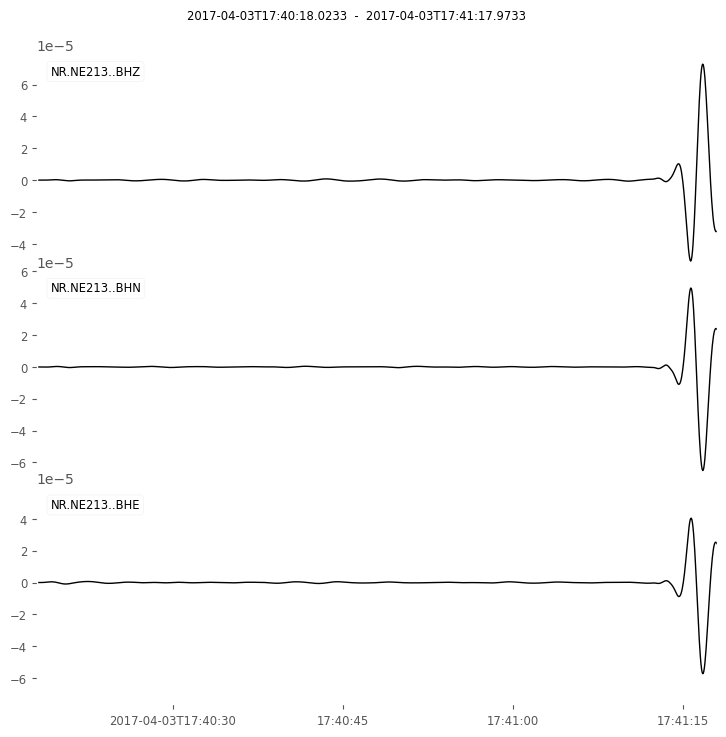

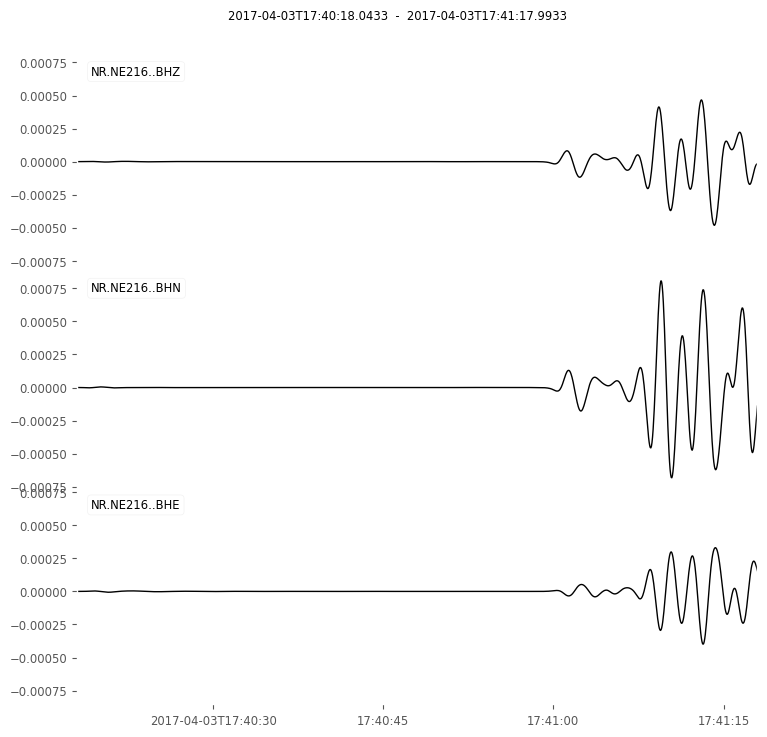

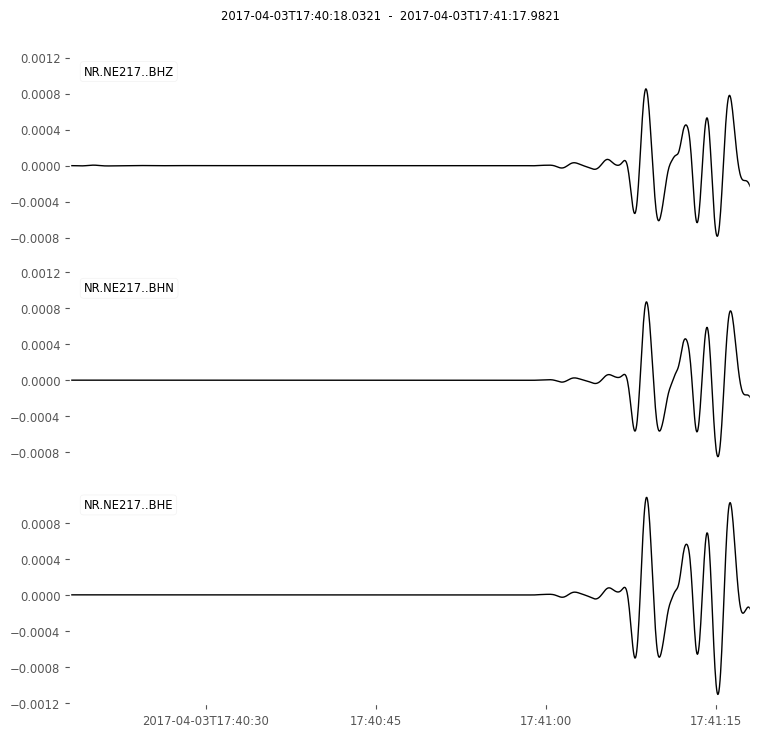

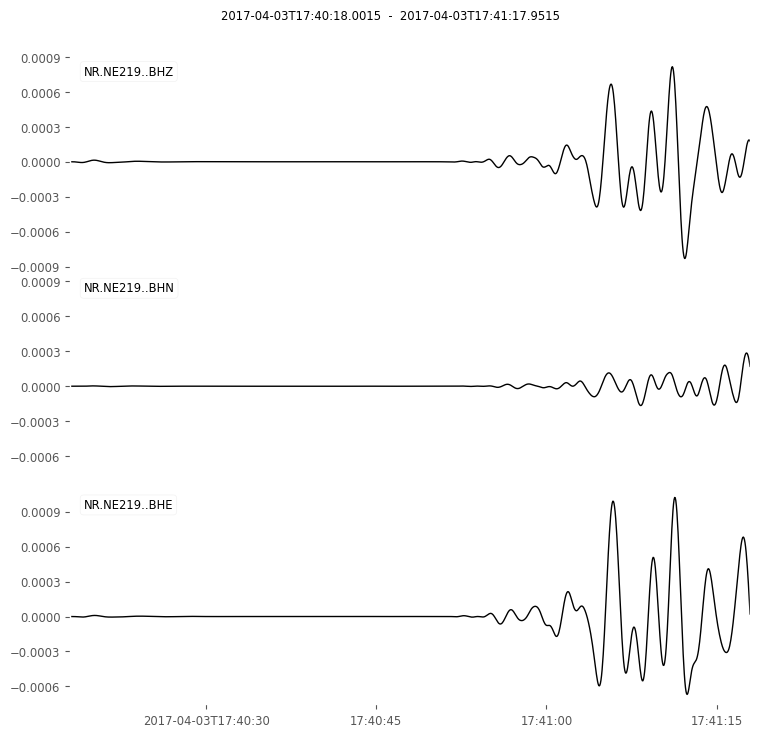

In [12]:
#Start here, change variable net and sta to download data from desired station
net = "NR"
#sta = "NE208"

List = ["NE208","NE211", "NE212", "NE213", "NE216","NE217","NE219"]
for sta in List:
    st = client.get_waveforms(net, sta, "*", "BH*", t, t+60, attach_response=True)
    st.remove_response(output="VEL")
    st2=st.copy()
    st2.detrend()
    st3=st2.copy()
    st3.filter("bandpass", freqmin=0.2, freqmax=0.6, corners=4)
    st3.plot()
#save data in mat format
    #BHZ - 0
    #BHN - 1
    #BHE - 2
    for i, tr in enumerate(st3):
        mdict = {k: str(v) for k, v in tr.stats.items()}
        mdict['data'] = tr.data
        savemat("data_filtered/data_60s_filtered-" + str(sta) + "_" + str(i) +".mat", mdict)
        